In [1]:
### Beginning by loading libraries and project data

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(2048)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

<mark> Will need to find a way to load in the data that does not require the use of additional files

### Start of Coherent Project Planning

#### Question to Explore: During the day, at what time do players who start playing tend to play for long periods of time at?

To answer this question, I will need to explore the start times of players, and the duration of play of the players. It may also be interesting to explore at what time the most players end their play sessions at in order to help with demand forecasting. 

For these reasons, I will only need to load in one of the datasets that is available to me. I will then need to select the start_time and end_time columns. I will need to transform this into tidy data, and mutate it to create a new column that has the duration of times played. Let's begin with these steps.

In [3]:
sessions_data <- read_csv("sessions.csv") |> select(-hashedEmail)
sessions_data

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<dbl>,<dbl>
30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮
28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [4]:
### Tidying the data


sessions_tidy <- sessions_data |>
                    select(start_time, end_time) |>
                    separate(col = start_time, into = c("date_start", "time_start"), sep = " ") |>
                    separate(col = end_time, into = c("date_end", "time_end"), sep = " ") |>
                    separate(col = date_start, into = c("day_start", "month_start", "year_start"), sep = "/") |>
                    separate(col = date_end, into = c("day_end", "month_end", "year_end"), sep = "/") |>
                    separate(col = time_start, into = c("hour_start", "minute_start"), sep = ":") |>
                    separate(col = time_end, into = c("hour_end", "minute_end"), sep = ":") 




sessions_tidy

day_start,month_start,year_start,hour_start,minute_start,day_end,month_end,year_end,hour_end,minute_end
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
30,06,2024,18,12,30,06,2024,18,24
17,06,2024,23,33,17,06,2024,23,46
25,07,2024,17,34,25,07,2024,17,57
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,07,2024,15,36,28,07,2024,15,57
25,07,2024,06,15,25,07,2024,06,22
20,05,2024,02,26,20,05,2024,02,45


I now need to make a column for the duration of the time that is played. I am more concerned with the **time** of day that players are playing at, rather than the month and year of their game play. Thus, I will remove the columns pertaining to month and year. I should be carful about the day columns though, because someone may have played through midnight.

In [5]:
sessions_days <- sessions_tidy |>
        select(-month_start, -year_start, -month_end, -year_end)

sessions_days
names(sessions_days)

day_start,hour_start,minute_start,day_end,hour_end,minute_end
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
30,18,12,30,18,24
17,23,33,17,23,46
25,17,34,25,17,57
⋮,⋮,⋮,⋮,⋮,⋮
28,15,36,28,15,57
25,06,15,25,06,22
20,02,26,20,02,45


[1] "day_start"    "hour_start"   "minute_start" "day_end"      "hour_end"    
[6] "minute_end"

I need to convert the characters to numbers so that I can manipulate the data

In [6]:
sessions_numeric <- sessions_days |>
        mutate(
            day_start = as.numeric(day_start), 
               minute_start = as.numeric(minute_start), 
               hour_start = as.numeric(hour_start),
               day_end = as.numeric(day_end),
               hour_end = as.numeric(hour_end),
               minute_end = as.numeric(minute_end)
              )
sessions_numeric

day_start,hour_start,minute_start,day_end,hour_end,minute_end
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30,18,12,30,18,24
17,23,33,17,23,46
25,17,34,25,17,57
⋮,⋮,⋮,⋮,⋮,⋮
28,15,36,28,15,57
25,6,15,25,6,22
20,2,26,20,2,45


I want to see if there are any cases where people played across multiple days, because I will need to handle those cases separately.

In [7]:
sessions_with_day_duration <- sessions_numeric |>
            mutate(day_duration = (day_end - day_start))
        


sessions_over_day <- sessions_with_day_duration |>
        filter(day_duration != 0)

sessions_under_day <- sessions_with_day_duration |>
        filter(day_duration == 0)

sessions_over_day
sessions_under_day

day_start,hour_start,minute_start,day_end,hour_end,minute_end,day_duration
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12,23,23,13,0,14,1
29,21,26,30,0,0,1
27,23,30,28,0,23,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,22,33,4,0,51,1
18,21,54,19,2,9,1
28,23,31,29,0,15,1


day_start,hour_start,minute_start,day_end,hour_end,minute_end,day_duration
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30,18,12,30,18,24,0
17,23,33,17,23,46,0
25,17,34,25,17,57,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,15,36,28,15,57,0
25,6,15,25,6,22,0
20,2,26,20,2,45,0


I also want to check to see if anyone played for over **2** days!

In [8]:
any_over_two <- sessions_over_day |>
        filter(day_duration > 1)

any_over_two

day_start,hour_start,minute_start,day_end,hour_end,minute_end,day_duration
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


As we see, the tibble is empty. Thus, we can conclude that there is no one who has a play time spanning more than one day.

Next, I want to deal with the easy case where the play time is over just one day and I can easily subtract the hours and minutes.

In [9]:
under_day_duration <- sessions_under_day |>
        mutate(duration_in_minutes = (hour_end * 60 + minute_end) - (hour_start *60 + minute_start) )

under_day_duration

day_start,hour_start,minute_start,day_end,hour_end,minute_end,day_duration,duration_in_minutes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30,18,12,30,18,24,0,12
17,23,33,17,23,46,0,13
25,17,34,25,17,57,0,23
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,15,36,28,15,57,0,21
25,6,15,25,6,22,0,7
20,2,26,20,2,45,0,19


How will I deal with the case where the playtime spans across multiple days? I need to treat this like I do when I am integrating a function in math and need to deal with the absolute values in the integral. I will calculate the duration until midnight, and then caluclate the duration after midnight

In [10]:
over_day_duration <- sessions_over_day |>
        mutate(hours_before_midnight = 24 - hour_start) |>
        mutate(minutes_before_midnight = 60 - minute_start) |>
        mutate(duration_in_minutes = hours_before_midnight * 60 + minutes_before_midnight + hour_end * 60 + minute_end) 


over_day_duration
    

day_start,hour_start,minute_start,day_end,hour_end,minute_end,day_duration,hours_before_midnight,minutes_before_midnight,duration_in_minutes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12,23,23,13,0,14,1,1,37,111
29,21,26,30,0,0,1,3,34,214
27,23,30,28,0,23,1,1,30,113
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,22,33,4,0,51,1,2,27,198
18,21,54,19,2,9,1,3,6,315
28,23,31,29,0,15,1,1,29,104


I now want to filter out the columns that are not necessary so that I can join these two tables back together again. 

I only want to have the hour_start, hour_end, minute_start, minute_end, and duration_in_minutes columns.

In [11]:
filtered_sessions_under <- under_day_duration |>
        select(hour_start, minute_start, hour_end, minute_end, duration_in_minutes)

filtered_sessions_over <- over_day_duration |>
        select(hour_start, minute_start, hour_end, minute_end, duration_in_minutes)


filtered_sessions_under
filtered_sessions_over

hour_start,minute_start,hour_end,minute_end,duration_in_minutes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,12,18,24,12
23,33,23,46,13
17,34,17,57,23
⋮,⋮,⋮,⋮,⋮
15,36,15,57,21
6,15,6,22,7
2,26,2,45,19


hour_start,minute_start,hour_end,minute_end,duration_in_minutes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23,23,0,14,111
21,26,0,0,214
23,30,0,23,113
⋮,⋮,⋮,⋮,⋮
22,33,0,51,198
21,54,2,9,315
23,31,0,15,104


Now I need to merge these into one data frame

In [12]:
sessions_joined <- full_join(filtered_sessions_under, filtered_sessions_over)

sessions_joined

Joining with `by = join_by(hour_start, minute_start, hour_end, minute_end,
duration_in_minutes)`


hour_start,minute_start,hour_end,minute_end,duration_in_minutes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,12,18,24,12
23,33,23,46,13
17,34,17,57,23
⋮,⋮,⋮,⋮,⋮
22,33,0,51,198
21,54,2,9,315
23,31,0,15,104


I now notice that I will need to somehow group together the start and end times. Thus, I will start by grouping together the hours

In [13]:
sessions_time_mins <- sessions_joined |>
        mutate(starting_minute = hour_start*60 + minute_start) |>
        mutate(ending_minute = hour_end*60 + minute_end)

sessions_time_mins

hour_start,minute_start,hour_end,minute_end,duration_in_minutes,starting_minute,ending_minute
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,12,18,24,12,1092,1104
23,33,23,46,13,1413,1426
17,34,17,57,23,1054,1077
⋮,⋮,⋮,⋮,⋮,⋮,⋮
22,33,0,51,198,1353,51
21,54,2,9,315,1314,129
23,31,0,15,104,1411,15


#### Beginning the visualization

I want to visualize what start time results in the longest duration of play. I will begin with a scatter plot, and from there I will decide if there is a better plot to visualize this data with.

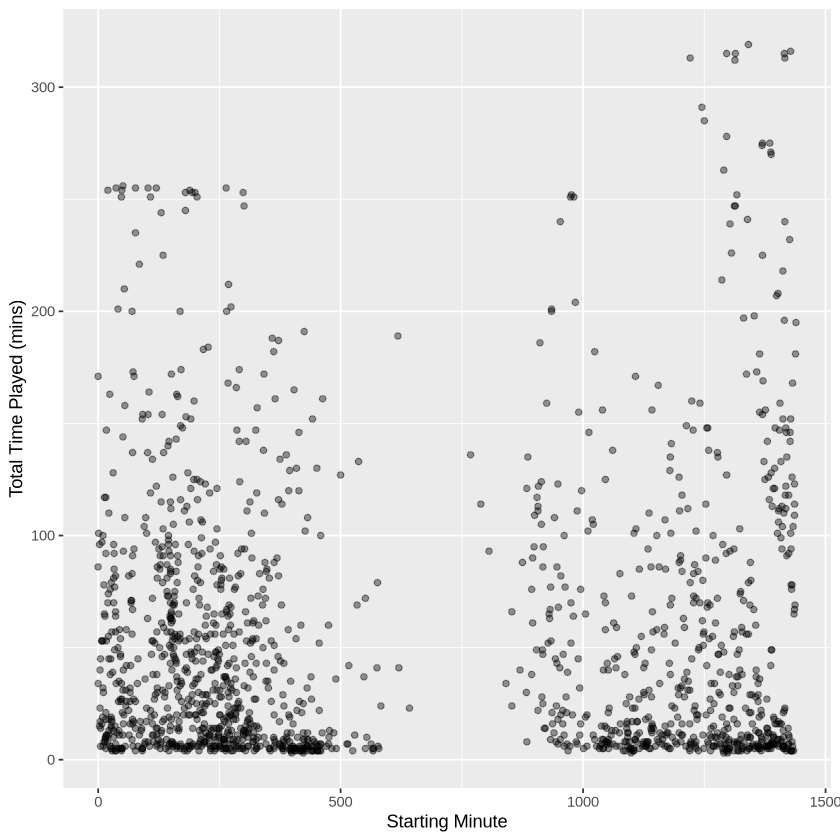

In [14]:
sessions_scatter <- sessions_time_mins |>
        ggplot(aes(x = starting_minute, y = duration_in_minutes)) +
        geom_point(alpha = 0.4) + 
        labs(x = "Starting Minute", y = "Total Time Played (mins)")


sessions_scatter

<mark> Note: finesse the stuff above a lot more for the final thing. Make actually good labels (i.e. make them actual times instead of just minutes), and maybe make multiple plots, with one to show the ending time as well. Could also include a bar chart to count the number of people playing in each hour. Remember that you need to show some kind of summary statistic, so it could be good to do some kind of bar chart of histogram. For now, I am moving on so that I have some kind of model to work with although I'm not really sure if the whole timing thing is going to cause an issue.

#### Creating a model using KNN regression

Since I have quantitative data, I want to to use knn regression to create a model that predicts the play time of a player based on their starting time.

I need to create a training set and a testing set of the data that I have worked so hard to tidy and manipulate. I almost forgot that I needed to create a test set, so I am very glad that I have remembered to take the following steps.

In [15]:
sessions_split <- initial_split(sessions_time_mins, prop = 0.75, strata = duration_in_minutes)

sessions_training <- training(sessions_split)

sessions_testing <- testing(sessions_split)

[1] 71

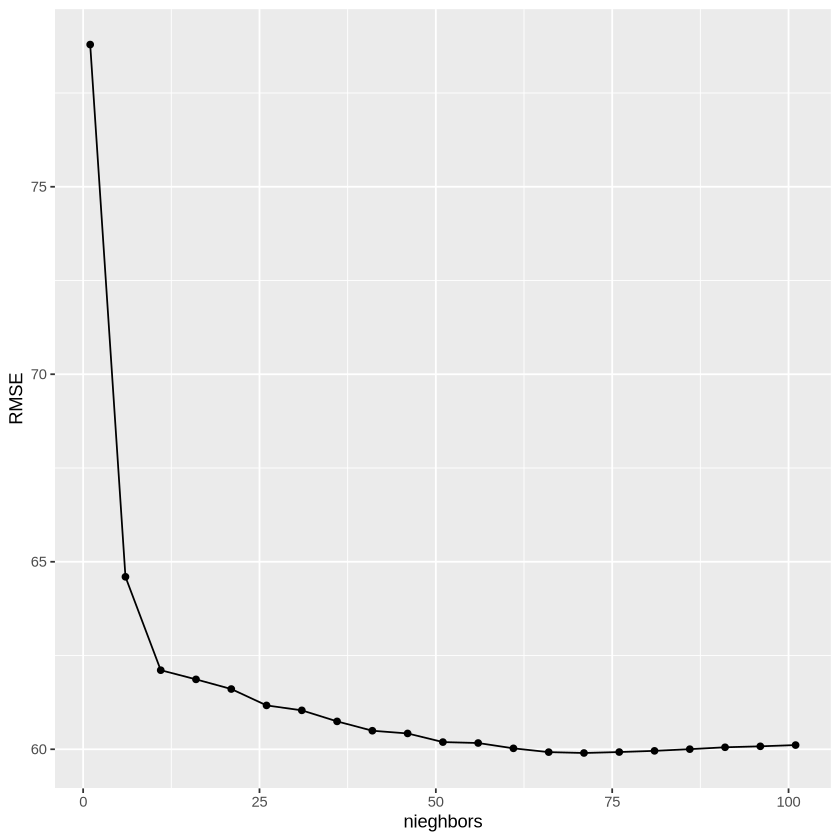

In [23]:
set.seed(2048)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("regression")


knn_recipe <- recipe(duration_in_minutes ~ starting_minute, data = sessions_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

knn_workflow <- workflow() |>
                add_model(knn_spec) |>
                add_recipe(knn_recipe)

##### Now for cross validation using 5 folds


knn_vfold <- vfold_cv(sessions_training, v = 5, strata = duration_in_minutes)

### Let's try 100 nearest neighbours

k_vals <- tibble(neighbors = seq(from = 1, to = 101, by = 5))


sessions_workflow <- knn_workflow |>
                    tune_grid(resamples = knn_vfold, grid = k_vals)
                    

sessions_workflow_results <- sessions_workflow |>
                             collect_metrics() |>
                             filter(.metric == "rmse")

k_plot <- sessions_workflow_results |>
            ggplot(aes(x = neighbors, y = mean)) +
            geom_point() +
            geom_line() +
            labs(x = "nieghbors", y = "RMSE")


best_k <- sessions_workflow_results |>
            filter(mean == min(mean)) |>
            select(neighbors) |>
            pull()
best_k
k_plot

I now make my best model using the value of k that I found (which was 71)

In [31]:
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
            set_engine("kknn") |>
            set_mode("regression")


best_workflow <- workflow() |>
                add_recipe(knn_recipe) |>
                add_model(best_spec) |>
                fit(data = sessions_training)


test_prediction <- best_workflow |>
                    predict(sessions_testing) |>
                    bind_cols(sessions_testing) |>
                    metrics(truth = duration_in_minutes, estimate = .pred) |>
                    filter(.metric == "rmse")


test_prediction

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,59.94383


#### Graph the predictions

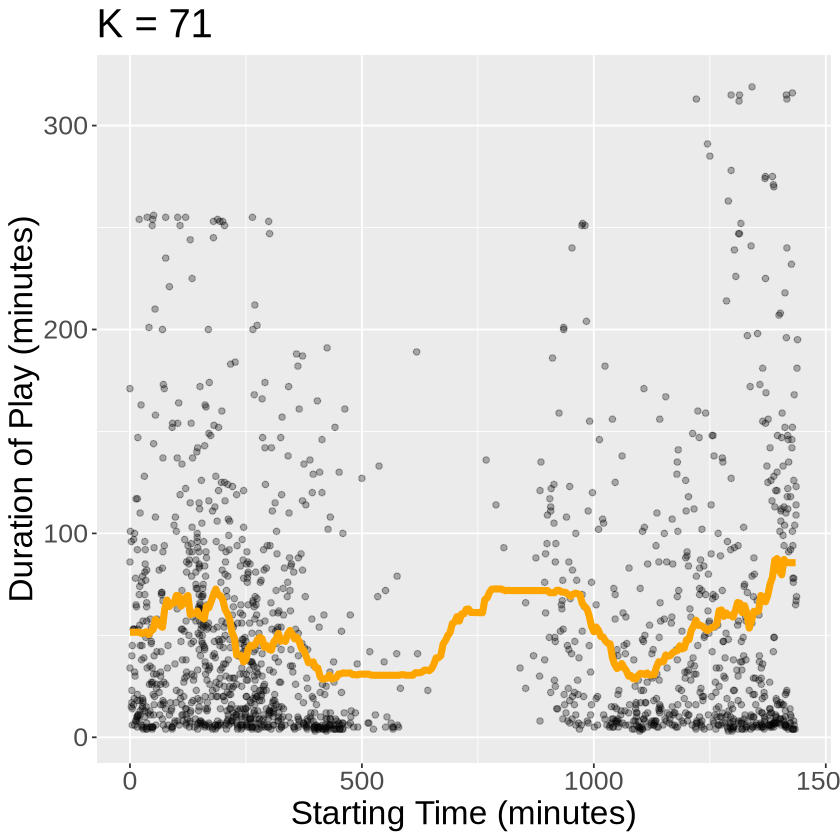

In [52]:
grid_of_estimates <- tibble(starting_minute = seq(from = sessions_time_mins |> select(starting_minute)|> min(), 
                                                      to = sessions_time_mins |> select(starting_minute) |> max(), 
                                                      by = 5))


snazzy_predictions <- best_workflow |>
                        predict(grid_of_estimates)|>
                        bind_cols(grid_of_estimates)





plot_with_line <- sessions_time_mins |>
                ggplot(aes(x = starting_minute, y = duration_in_minutes)) +
                geom_point(alpha = 0.3) +
                geom_line(data = snazzy_predictions, 
                         mapping = aes(x = starting_minute, .pred),
                         color = "orange",
                         linewidth = 2) +
                labs(x = "Starting Time (minutes)", y = "Duration of Play (minutes)") + 
                theme(text = element_text(size = 20)) +
                ggtitle("K = 71")

plot_with_line